In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
Ravadess = "/content/drive/MyDrive/AllAudioFiles/"

In [5]:
Ravadess_directory_list = os.listdir(Ravadess)

file_emotion = []
file_path = []

for file in Ravadess_directory_list:
    # storing file paths
    file_path.append(Ravadess + file)
    # storing file emotions
    part=file.split('_')
    if part[3] == 'S':
       file_emotion.append('sad')
    elif part[3] == 'A':
      file_emotion.append('angry')
    elif part[3] == 'H':
      file_emotion.append('happy')
    elif part[3] == 'N':
      file_emotion.append('neutral')
    else:
      file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravadess_df = pd.concat([emotion_df, path_df], axis=1)
Ravadess_df.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/AllAudioFiles/M_004_T_N...
1,neutral,/content/drive/MyDrive/AllAudioFiles/M_004_T_N...
2,neutral,/content/drive/MyDrive/AllAudioFiles/M_004_T_N...
3,neutral,/content/drive/MyDrive/AllAudioFiles/M_004_T_N...
4,neutral,/content/drive/MyDrive/AllAudioFiles/M_004_T_N...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


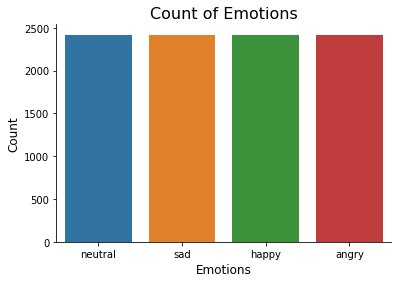

In [6]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravadess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

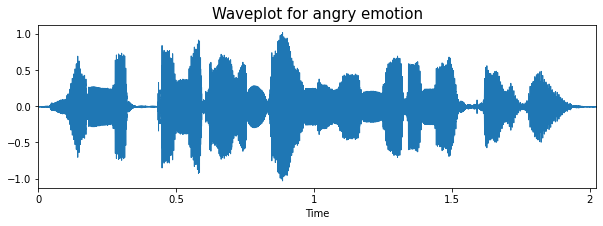

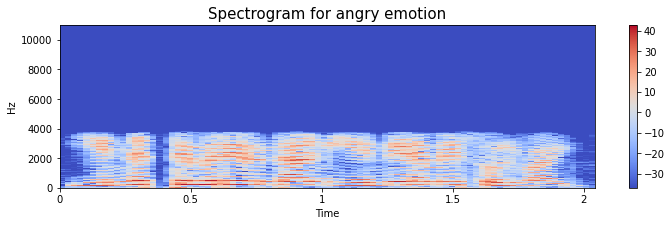

In [8]:
emotion='angry'
path = np.array(Ravadess_df.Path[Ravadess_df.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [9]:
labels = {'sad':0,'angry':1,'happy':2,'neutral':3,'unknown':4}
Ravadess_df.replace({'Emotions':labels},inplace=True)

In [10]:
num_mfcc=13
n_fft=2048
hop_length=512
SAMPLE_RATE = 22050
data = {
        "labels": [],
        "mfcc": []
    }
for i in range(7442):
    data['labels'].append(Ravadess_df.iloc[i,0])
    signal, sample_rate = librosa.load(Ravadess_df.iloc[i,1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i%500==0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [11]:
X = np.asarray(data['mfcc'])
y = np.asarray(data["labels"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [12]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(7442, 789, 13)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [14]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(5357, 789, 13) (5357,) (1340, 789, 13) (1340,) (745, 789, 13) (745,)


In [15]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6, activation='softmax'))

    return model

In [16]:
input_shape = (None,13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 126,662
Trainable params: 126,662
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
168/168 [==============================] - 181s 1s/step - loss: 1.0382 - accuracy: 0.5468 - val_loss: 0.7090 - val_accuracy: 0.7090
Epoch 2/30
168/168 [==============================] - 177s 1s/step - loss: 0.7314 - accuracy: 0.6989 - val_loss: 0.7326 - val_accuracy: 0.7022
Epoch 3/30
168/168 [==============================] - 176s 1s/step - loss: 0.6669 - accuracy: 0.7314 - val_loss: 0.5532 - val_accuracy: 0.7754
Epoch 4/30
168/168 [==============================] - 177s 1s/step - loss: 0.5602 - accuracy: 0.7779 - val_loss: 0.4919 - val_accuracy: 0.8090
Epoch 5/30
168/168 [==============================] - 178s 1s/step - loss: 0.5210 - accuracy: 0.7984 - val_loss: 0.4779 - val_accuracy: 0.8112
Epoch 6/30
168/168 [==============================] - 177s 1s/step - loss: 0.4677 - accuracy: 0.8191 - val_loss: 0.6075 - val_accuracy: 0.7545
Epoch 7/30
168/168 [==============================] - 176s 1s/step - loss: 0.4528 - accuracy: 0.8270 - val_loss: 0.4212 - val_accuracy: 0.8284

In [18]:
testing_loss, testing_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",testing_accuracy)

Test Accuracy:  0.9073825478553772
